In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
directory = ""
image_directory = "../Volumes/SeagateANNI/face mask recognition/archive/Medical mask/Medical mask/Medical Mask/annotations"
df = pd.read_csv("../face mask recognition/archive/train.csv")
df_test = pd.read_csv("../face mask recognition/archive/submission.csv")



HELPER FUNCTION

In [3]:
caffemodel_path = 'weights.caffemodel'
prototxt_path = 'deploy.prototxt'
cvNet = cv2.dnn.readNetFromCaffe(prototxt_path,caffemodel_path)
def getJSON(filePathandName):
    with open(filePathandName,'r',encoding='windows-1252') as f:
        return json.load(f)
# def getJSON(filePathandName):
#     encodings = ['utf-8', 'windows-1252', 'latin1', 'iso-8859-1']
#     for encoding in encodings:
#         try:
#             with open(filePathandName, 'r', encoding=encoding) as f:
#                 return json.load(f)
#         except (UnicodeDecodeError, json.JSONDecodeError):
#             continue
#     print(f"Error reading or decoding JSON from file: {filePathandName}")
#     return None
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))



DATA PROCESSING

In [4]:
directory = "archive/Medical mask/Medical mask/Medical Mask/annotations"
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [5]:
df = pd.read_csv("archive/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


The faces of a image are extracted and stored in the data list with its tag for the learning process.

<Axes: xlabel='count'>

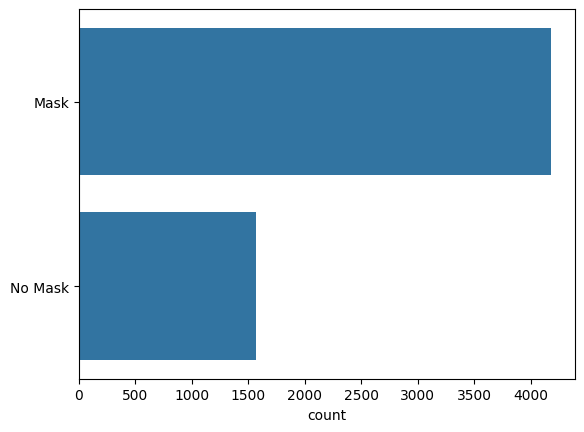

In [8]:
annotation_directory = "archive/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "archive/Medical mask/Medical mask/Medical Mask/images"
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

reshape the data before training a neural network

In [9]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

Training Neural Network for Face Mask Detection

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(        
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=5,
                    verbose=1,
                    validation_data=(xval, yval))

/Volumes/SeagateANNI/face mask recognition/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/Volumes/SeagateANNI/face mask recognition/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 465s 3s/step - accuracy: 0.7769 - loss: 0.5115 - val_accuracy: 0.9104 - val_loss: 0.2277
Epoch 2/5
  1/143 ━━━━━━━━━━━━━━━━━━━━ 7:12 3s/step - accuracy: 0.8750 - loss: 0.3003

2024-07-17 20:12:25.971072: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.8750 - loss: 0.3003 - val_accuracy: 0.9070 - val_loss: 0.2292
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.8867 - loss: 0.2907 - val_accuracy: 0.9043 - val_loss: 0.2249
Epoch 4/5
  1/143 ━━━━━━━━━━━━━━━━━━━━ 7:20 3s/step - accuracy: 0.8750 - loss: 0.4011

2024-07-17 20:21:18.544727: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.8750 - loss: 0.4011 - val_accuracy: 0.9009 - val_loss: 0.2283
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - accuracy: 0.8980 - loss: 0.2561 - val_accuracy: 0.9296 - val_loss: 0.1888


Detection 0 - Confidence: 2.1339296552014275e-07
Detection 1 - Confidence: 5.51000027826376e-07
Detection 2 - Confidence: 3.508976362809335e-07
Detection 3 - Confidence: 8.51350350217217e-08
Detection 0 - Confidence: 2.2462096183062386e-07
Detection 1 - Confidence: 2.0576781878389738e-07
Detection 2 - Confidence: 1.5688932819557522e-08
Detection 3 - Confidence: 7.572879545669764e-10
Detection 0 - Confidence: 3.7591180168661253e-11
Detection 1 - Confidence: 1.1790503295916466e-10
Detection 2 - Confidence: 1.0773245628925565e-09
Detection 3 - Confidence: 3.3165332702367323e-09
Detection 0 - Confidence: 2.3156094067809457e-16
Detection 1 - Confidence: 8.718015141209962e-16
Detection 2 - Confidence: 1.7447083003590408e-15
Detection 3 - Confidence: 1.187589637598825e-15
Detection 0 - Confidence: 5.347204883737744e-13
Detection 1 - Confidence: 6.001421554808692e-15
Detection 2 - Confidence: 1.8509927769706487e-16
Detection 3 - Confidence: 1.6906650572253747e-15
Detection 0 - Confidence: 4.49

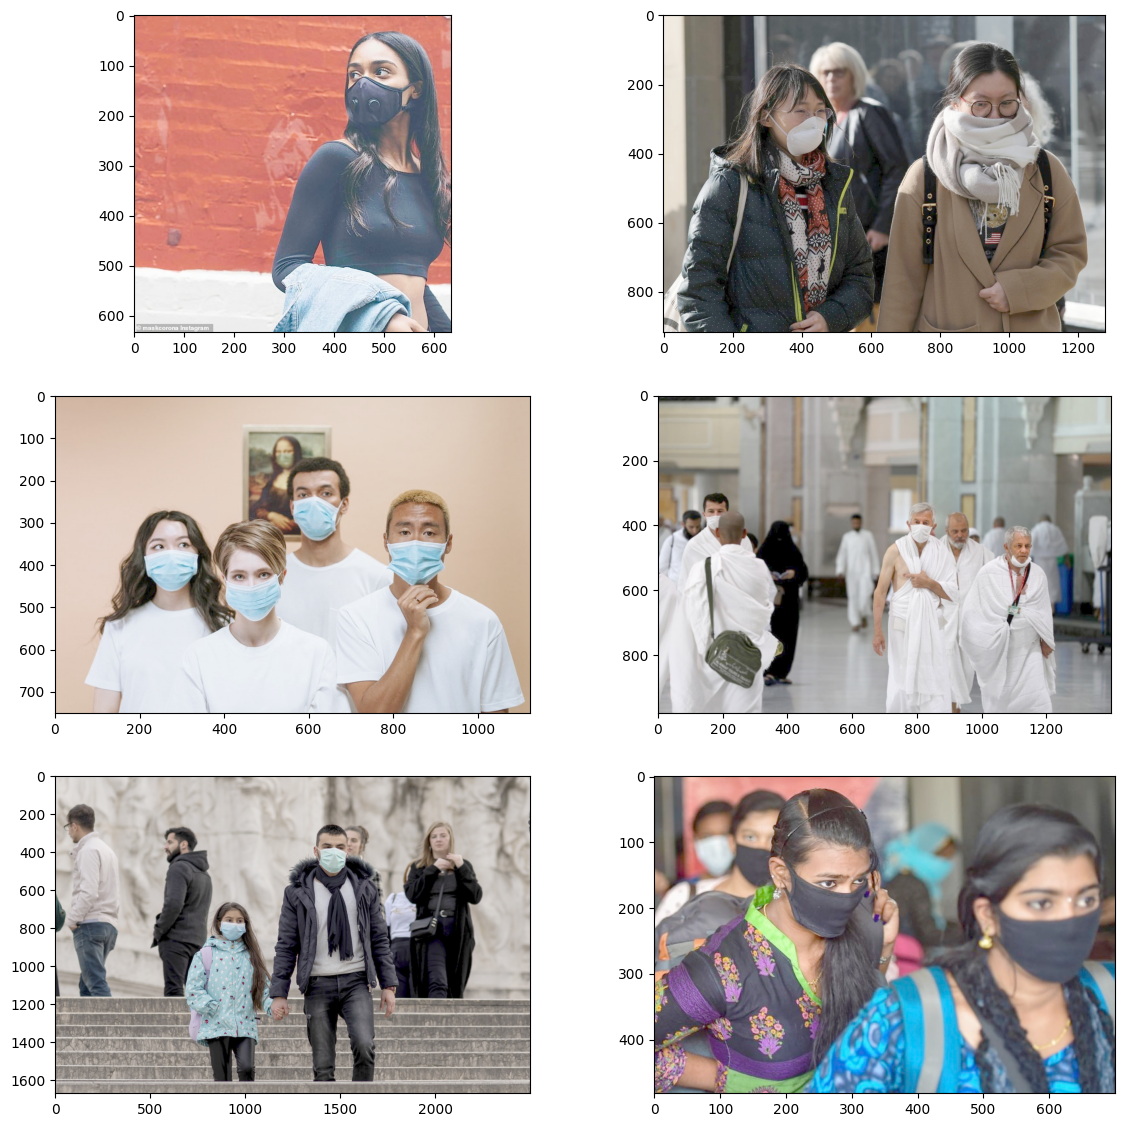

In [13]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

for j, im in enumerate(test_images):
    image = cv2.imread(os.path.join(image_directory, im), 1)
    if image is None:
        print(f"Could not read image {im}")
        continue
    
    image = adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()

    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            print(f"Detection {i} - Confidence: {confidence}")
            
            if confidence > 0.2:
                im = cv2.resize(frame, (img_size, img_size))
                im = np.array(im) / 255.0
                im = im.reshape(1, 124, 124, 3)
                result = model.predict(im)
                print(f"Prediction result: {result}")
                
                if result > 0.5:
                    label_Y = 1
                else:
                    label_Y = 0

                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image, assign[str(label_Y)], (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36, 255, 12), 2)

        except Exception as e:
            print(f"Error processing detection {i}: {e}")
            pass

    axes.append(fig.add_subplot(rows, cols, j + 1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()